# AIVLE스쿨 2차 미니프로젝트: 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 3: 모델링

## [미션]

- 모델링을 수행합니다.
    - 전처리를 추가로 진행합니다.
    - 4개 이상의 알고리즘을 사용해 모델링을 수행합니다.
    - 각 모델에 대해 성능 튜닝을 수행합니다.
    - 성능을 비교해 최선의 모델을 선정합니다.
- 데이터 파이프라인 함수를 만듭니다.
- 새로운 데이터를 읽어와 예측을 수행합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [49]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [51]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [ ]:
# 한글 표시를 위한 라이브러리 설치
#!pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [53]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 모델링용 라이브러리 불러오기

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import xgboost as xgb

from sklearn.metrics import r2_score

# 기타 라이브러리 불러기기
import joblib
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- joblib.dump() 함수를 사용해 base_data2.pkl 파일을 읽어옵니다.
- 읽어온 데이터를 data 데이터프레임으로 선언하고 기본 정보를 확인합니다.

In [55]:
# 파일 읽어오기
data = joblib.load(path+'base_data2.pkl')

# 확인
data.head()

,총세대수,건물형태,난방방식,승강기설치여부,실차량수,준공연도,총면적,면적16_26,면적26_38,면적38_46,면적46_51,면적51_59,면적59_74,면적74_85,면적85_127,면적127_140,임대보증금,임대료
3,477,복도식,지역,1,943,2014,47058.9273,0,0,0,0,0,199,278,0,0,1.015167e+08,950305.000000
4,15,복도식,개별,1,21,2013,543.0268,14,1,0,0,0,0,0,0,0,5.522750e+07,340148.333333
5,69,계단식,개별,1,830,2014,4802.4651,0,26,0,0,43,0,0,0,0,2.878033e+07,450920.000000
10,908,계단식,지역,1,1119,2018,91706.2788,0,0,0,0,0,756,152,0,0,6.133333e+07,573333.333333
11,160,계단식,지역,1,556,2014,20155.8967,0,0,0,0,0,43,146,0,0,3.609400e+07,634472.500000


### (6) 함수 생성

- 실젯값과 모델이 예측한 값을 시각화해 비교할 함수를 만듭니다.

In [ ]:
# 실젯값, 예측값 비교 함수 만들기
# def model_plot(y_test, y_pred):
#     plt.figure(figsize=(10, 3))
#     plt.plot(y_test.values, label='Actual', linewidth=0.7, marker='o', markersize=2)
#     plt.plot(y_pred, label='Predicted', linewidth=0.7, marker='o', markersize=2)
#     plt.legend()
#     plt.show()

## 2. 모델링

- 모델링을 위한 결측치 처리, 데이터 분할, 스케일링, 가변수화 등을 수행합니다.
- 4개 이상의 알고리즘을 사용하여 모델을 만듭니다.
- 모델 이름은 서로 다르게 합니다. (예: model1, model2...)
- Linear Regression 이외의 알고리즘을 사용한 모델은 GridSearchCV() 함수로 성능 최적화를 수행합니다.
- 적절한 평가지표로 모델의 성능을 평가합니다.
- 실젯값과 예측값을 시각화해 비교합니다.
- 성능 비교를 통해 최선의 모델을 선정합니다.

### (1) 데이터 전처리

- 필요한 전처리를 수행합니다.

#### 1) 가변수화

- '건물형태', '난방방식' 변수에 대해 가변수화를 수행합니다.

In [57]:
dumm_cols=['건물형태', '난방방식']
data=pd.get_dummies(data,columns=dumm_cols,drop_first=True,dtype=int)


#### 2) x, y 분리

- Target를 지정하고, x와 y로 분리합니다.

In [59]:
target='실차량수'

x=data.drop(columns=target)
y=data.loc[:,target]



#### 3) 학습용, 평가용 분리

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.

In [61]:

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)


#### 4) 스케일링

- 필요한 경우 스케일링을 진행합니다.
- 예를 들어 KNN 알고리즘을 사용할 경우입니다.

In [63]:

scaler=MinMaxScaler()
scaler.fit(x_train)
x_train_s=scaler.transform(x_train)
x_test_s=scaler.transform(x_test)


### (2) 모델 1: 알고리즘

In [65]:
cv_score=cross_val_score(LinearRegression(),x_train,y_train,cv=10)

result={}
result['LinearRegression']=cv_score.mean
print('R2 : ',cv_score.mean())

R2 :  0.8559406097251184


### (3) 모델 2: 알고리즘


In [67]:
cv_score=cross_val_score(KNeighborsRegressor(),x_train_s,y_train,cv=10)

result['KNeighborsRegressor']=cv_score.mean()
print('R2 : ',cv_score.mean())

R2 :  0.7291045926310289


### (4) 모델 3: 알고리즘

In [69]:
cv_score=cross_val_score(DecisionTreeRegressor(max_depth=5),x_train_s,y_train,cv=10)

result['DecisionTreeRegressor']=cv_score.mean()
print('R2 : ',cv_score.mean())

R2 :  0.7843731442434836


### (5) 모델 4: 알고리즘

In [71]:
cv_score=cross_val_score(RandomForestRegressor(max_depth=5),x_train_s,y_train,cv=10)

result['RandomForestRegressor']=cv_score.mean()
print('R2 : ',cv_score.mean())

R2 :  0.8613098629598751


### (6) 모델 5: 알고리즘

In [73]:
cv_score=cross_val_score(LGBMRegressor(verbose=-1),x_train_s,y_train,cv=10)

result['LGBMRegressor']=cv_score.mean()
print('R2 : ',cv_score.mean())

R2 :  0.8574707293536518


In [103]:
for i in result:
    print(f'{i} = {result[i]}')

LinearRegression = 0.8559406097251184
KNeighborsRegressor = 0.7291045926310289
DecisionTreeRegressor = 0.7843731442434836
RandomForestRegressor = 0.8613098629598751
LGBMRegressor = 0.8574707293536518


### (7) 성능 비교

- 각 모델의 성능을 비교합니다.

<BarContainer object of 5 artists>

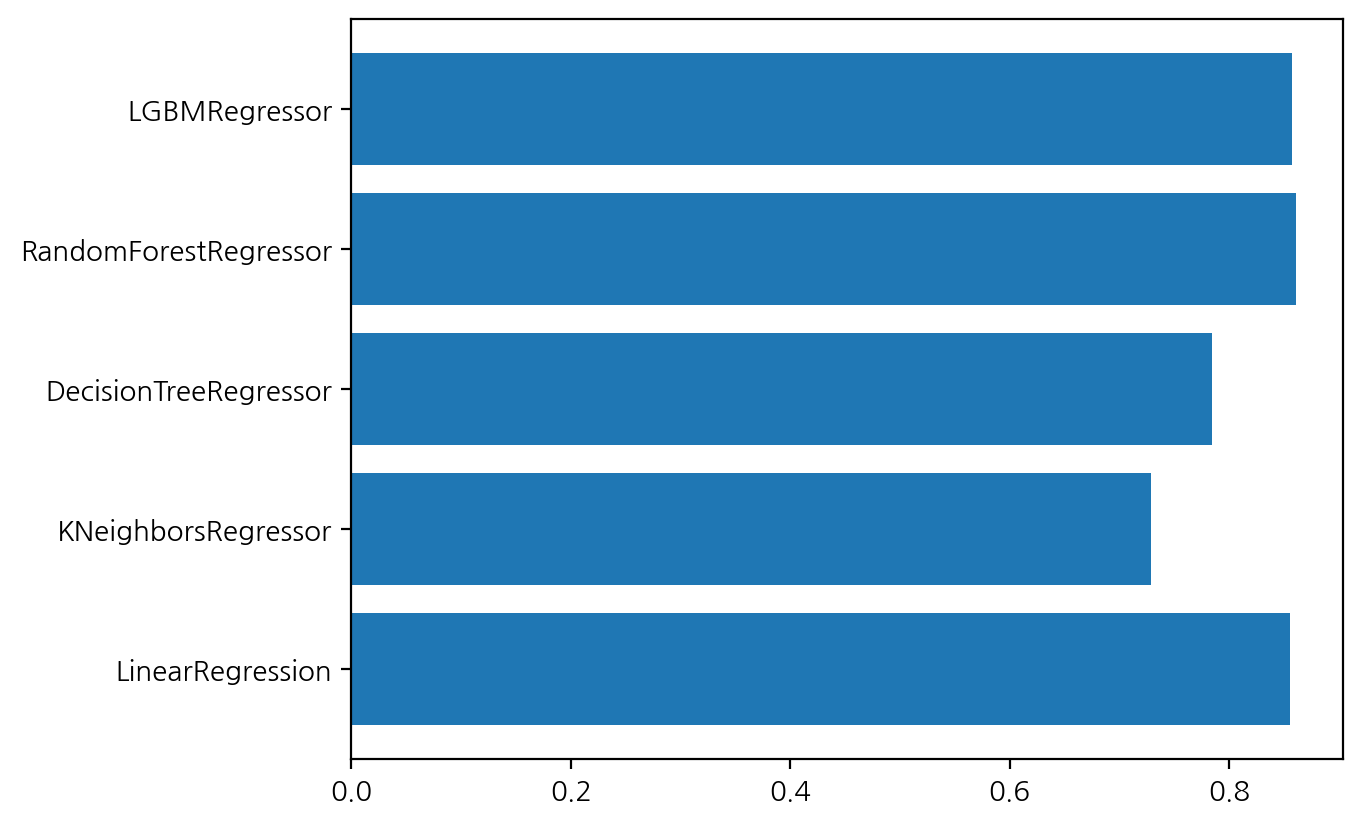

In [75]:

plt.barh(y=list(result),width=result.values())


## 3. 파이프라인 구축

- 새로운 데이터를 불러오고, 이 데이터를 처리할 파이프라인 함수를 만듭니다.

### (1) New Data 불러오기

- test.xlsx 파일을 읽어와 new_data 데이터프레임으로 선언합니다.
- 해당 데이터는 '실차량수' 변수가 없는 것 외에는, 최초 데이터와 동일한 구조입니다.
- 이 데이터를 대상으로 전처리와 예측을 수행합니다.

In [77]:
# 파일 읽어오기
new_data = pd.read_excel(path+'test.xlsx')

# 확인
new_data.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료
0,C0005,서울석촌 도시형주택(공임10년),20,6,서울,20121115,복도식,개별가스난방,전체동 설치,9,17.53,11.7251,50449000,263710
1,C0005,서울석촌 도시형주택(공임10년),20,10,서울,20121115,복도식,개별가스난방,전체동 설치,9,24.71,16.5275,52743000,321040
2,C0005,서울석촌 도시형주택(공임10년),20,4,서울,20121115,복도식,개별가스난방,전체동 설치,9,26.72,17.8720,53890000,332510
3,C0017,대구혁신센텀힐즈,822,228,대구경북,20180221,계단식,지역난방,NaN,824,51.87,20.9266,29298000,411200
4,C0017,대구혁신센텀힐즈,822,56,대구경북,20180221,계단식,지역난방,NaN,824,59.85,24.1461,38550000,462600


In [79]:
new_data.isna().sum()

단지코드        0
단지명         0
총세대수        0
전용면적별세대수    0
지역          0
준공일자        0
건물형태        4
난방방식        1
승강기설치여부     9
단지내주차면수     0
전용면적        0
공용면적        0
임대보증금       0
임대료         0
dtype: int64

In [81]:
x_train.head()

,총세대수,승강기설치여부,준공연도,총면적,면적16_26,면적26_38,면적38_46,면적46_51,면적51_59,면적59_74,면적74_85,면적85_127,면적127_140,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
125,350,1,2004,26594.9874,0,0,0,0,347,3,0,0,0,37409250.0,300527.5,1,0,0,1
117,476,1,1995,26317.6800,0,476,0,0,0,0,0,0,0,10319000.0,146130.0,1,0,0,0
245,2289,1,2011,142698.5412,0,1252,0,670,367,0,0,0,0,33853600.0,224820.0,1,0,0,1
158,705,1,2005,42879.3615,0,294,411,0,0,0,0,0,0,21657500.0,181760.0,1,0,0,1
317,528,1,2006,35206.7755,0,0,0,174,224,110,0,0,0,19662000.0,159777.5,0,1,0,0


### (2) 데이터 파이프라인 구축

- 데이터 파이프라인 함수를 만듭니다.
- 학습 데이터에 대해 진행했던 모든 전처리 과정을 평가 데이터에도 일괄 진행해야 합니다.
    - 입력: new_data
    - 출력: 전처리가 완료된 예측 직전 데이터프레임
- 새로운 데이터에는 '실차량수' 변수가 없음을 유의합니다.
- 참고: 다음 내용들이 처리되어야 합니다.
    - 결측치 처리
    - 변수 추가
    - 불필요한 변수 제거
    - 단지 데이터, 상세 데이터 분리
    - 단지코드별 총면적 합 집계
    - 전용면적 구간별 집계 (피벗 형태)
    - 임대보증금, 임대료 평균 집계
    - 집계 결과 병합
    - 난방방식: 개별, 지역, 중앙 세 가지로 묶기
    - 승강기설치여부: 0, 1 값으로 변경
    - 단지모드, 지역 변수 제거
    - 가변수화

In [83]:
# XGBClassifier를 이용해 결측치 채우기
def train_and_predict_missing_values(df, target_column):
    # 결측치가 있는 행과 없는 행으로 분리
    train_data = df[df[target_column].notnull()]
    test_data = df[df[target_column].isnull()]
    
    if len(test_data) == 0:
        return df  # 결측치가 없는 경우 예측할 필요가 없음
    
    # 변수 분리~
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    
    X_train_encoded = pd.get_dummies(X_train, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, drop_first=True)

    # 학습 데이터와 테스트 데이터의 열을 동일하게 맞춤
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)
    
    # 타겟 변수 레이블 인코딩
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    
    model = xgb.XGBClassifier()
    model.fit(X_train_encoded, y_train_encoded)

    y_pred_encoded = model.predict(X_test_encoded)
    
    y_pred = le.inverse_transform(y_pred_encoded)

    df.loc[df[target_column].isnull(), target_column] = y_pred
    return df


In [93]:
# 파이프라인 만들기
def data_pipeline(data):
    apt01 = data.copy()
    
    categorical_columns_with_nan = ['건물형태', '난방방식', '승강기설치여부']
        
    for col in categorical_columns_with_nan:
        apt01 = train_and_predict_missing_values(apt01, col)

    apt01['준공연도'] = apt01['준공일자'].astype(str).str[:4].astype(int)
    apt01['총면적'] = (apt01['전용면적'] + apt01['공용면적']) * apt01['전용면적별세대수']

    apt01.drop(columns = '준공일자', inplace=True)

    data01 = apt01[['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부']]

    data01.drop_duplicates(inplace=True)
    
    data01.reset_index(drop=True, inplace=True)
    
    data02 = apt01[['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
    
    df_area = data02.groupby('단지코드')['총면적'].sum().reset_index()

    bins = [16, 26, 38, 46, 51, 59, 74, 85, 127, 140]
    labels = ['면적16_26', '면적26_38', '면적38_46', '면적46_51', '면적51_59', '면적59_74', '면적74_85', '면적85_127', '면적127_140']
    data02['전용면적구간'] = pd.cut(data02['전용면적'], bins=bins, labels=labels, right=False)
    
    temp = data02.groupby(['단지코드', '전용면적구간'])['전용면적별세대수'].sum().reset_index()

    df_pivot = temp.pivot(index='단지코드', columns='전용면적구간', values='전용면적별세대수')
    df_pivot.columns.name = None
    df_pivot.reset_index(inplace=True)

    df_rent = data02.groupby('단지코드')[['임대보증금', '임대료']].mean().reset_index()

    base_data = pd.merge(data01, df_area, on='단지코드', how='left')
    base_data = pd.merge(base_data, df_pivot, on='단지코드', how='left')
    base_data = pd.merge(base_data, df_rent, on='단지코드', how='left')

    base_data['난방방식'] = base_data['난방방식'].replace(
        {
        '개별가스난방': '개별',
        '개별유류난방': '개별',
        '지역난방': '지역',
        '지역가스난방': '지역',
        '지역유류난방': '지역',
        '중앙가스난방': '중앙',
        '중앙난방': '중앙',
        '중앙유류난방': '중앙'
        }
    )
    base_data['난방방식']

    base_data['승강기설치여부'] = base_data['승강기설치여부'].replace({'전체동 설치':1, '일부동 설치':0, '미설치':0})

    base_data.drop(columns=['단지코드', '지역'], inplace = True)

    return base_data

### (3) 예측하기

- new_data를 파이프라인을 사용해 전처리한 후 가장 성능이 좋았던 모델로 예측한 결과를 확인합니다.

In [95]:
# 데이터 전처리
data = data_pipeline(new_data)

# 확인
data.head()

,총세대수,준공연도,건물형태,난방방식,승강기설치여부,총면적,면적16_26,면적26_38,면적38_46,면적46_51,면적51_59,면적59_74,면적74_85,면적85_127,면적127_140,임대보증금,임대료
0,20,2012,복도식,개별,1,766.2736,16,4,0,0,0,0,0,0,0,5.236067e+07,305753.333333
1,822,2018,계단식,지역,1,31396.0944,0,0,0,0,228,176,0,0,0,3.546600e+07,445466.666667
2,112,2014,계단식,지역,1,12450.4308,0,0,0,0,0,0,112,0,0,9.869750e+07,744450.000000
3,122,2011,계단식,지역,1,13081.4772,0,0,0,0,0,0,122,0,0,0.000000e+00,0.000000
4,262,2011,계단식,지역,1,28141.7516,0,0,0,0,0,0,262,0,0,0.000000e+00,0.000000


In [106]:
#GridSearchCV로 최적의 RandomForestRegressor찾기

param={'max_depth':range(1,51)}

model=GridSearchCV(RandomForestRegressor(),param,cv=10)


In [108]:
model.fit(x_train_s,y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 51)})

In [110]:
# 예측하기
predicted = model.predict(data)

# 확인
print(predicted)

ValueError: could not convert string to float: '복도식'

- 아파트 기본 정보에 예측한 차량수를 붙여 마무리합니다.

In [ ]:
# 데이터 셋 두개로 나누기
vars = ['단지코드', '단지명', '총세대수', '지역', ]
result = new_data[vars].copy()
result = result.drop_duplicates()
result.reset_index(drop=True, inplace=True)

# 예측 결과 추가
result['예상차량수'] = predicted.round(1).astype(int)

# 확인
result

## 4.최적의 모델 찾기()

In [ ]:
!pip install mljar-supervised

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from supervised import AutoML

In [ ]:
apart['건물형태'] = apart['건물형태'].astype('category')
apart['난방방식'] = apart['난방방식'].astype('category')
# apart['승강기설치여부'] = apart['승강기설치여부'].astype('category')
X = apart.drop(columns=['실차량수'])  # 독립 변수 (피처)
y = apart['실차량수']  # 종속 변수 (타겟)

# 데이터셋을 학습용과 테스트용으로 분리 (70% 학습, 30% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

automl = AutoML(mode="Perform",  # Perform 모드 사용 (성능 최적화)
                total_time_limit=900,  # 전체 학습 시간 제한 (초 단위)
                explain_level=2)  # 0 (none), 1 (basic), 2 (intermediate), 3 (advanced)

# 학습 데이터로 모델 학습
automl.fit(X_train, y_train)


In [ ]:

# 모델 성능 평가 (Mean Squared Error)
from sklearn.metrics import mean_squared_error
# 모델 성능 평가 (R^2 Score)
from sklearn.metrics import r2_score

# 테스트 데이터로 예측 수행
y_pred = automl.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")